In [1]:
import pylab
import h5py
import math
import pycbc.types
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm

import lal
import lalsimulation as ls

from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker


plt.style.reload_library()
#plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=15) 
#pylab.rc('ytick', labelsize=15) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)

In [ ]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion

#%run GW_functions.ipynb 
#%run Match_Functions_Circular.ipynb

In [ ]:
%run Model_22_Updated.ipynb

In [ ]:
q0 = 1
Mass_total=50
Mass1=q0*Mass_total/(1+q0)
Mass2=Mass_total/(1+q0)

M_SI = Mass_total*MSUN_SI
D_SI=(10**(6))*PC_SI
mode2polfac=4*(5/(64*np.pi))**(1/2)

hp_enigma, hc_enigma = ls.SimInspiralChooseTDWaveform(Mass1 * lal.MSUN_SI, Mass2 * lal.MSUN_SI, 0, 0, 0, 0, 0, 
                                                      0, D_SI, 0, 0, 0, 0.172, 0, 1./4096, 20, 20, None, ls.IMRENIGMA)
timeE = 1/4096 * np.arange(len(hp_enigma.data.data))  

In [ ]:
hp_enigma, hc_enigma = ls.SimInspiralChooseTDWaveform(Mass1 * lal.MSUN_SI, Mass2 * lal.MSUN_SI, 0, 0, 0, 0, 0, 
                                                      0, D_SI, 0, 0, 0, 0.172, 0, 1./4096, 20, 20, None, ls.IMRENIGMA)
timeE = 1/4096 * np.arange(len(hp_enigma.data.data))  

In [ ]:
#plt.plot(timeE,hp_enigma.data.data)
#len(hp_enigma)

In [73]:
Mtot = np.linspace(35,100,34)

In [74]:
def enigma_gen(M,q,e0,fmin,fref,delta_t):
    
    mass_1 = q/(1+q) * M * MSUN_SI
    mass_2 = 1/(1+q) * M * MSUN_SI
    dL = (10**6) * PC_SI
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    
    hp_en, hc_en = ls.SimInspiralChooseTDWaveform(mass_1, mass_2, 0, 0, 0, 0, 0, 
                                                      0, dL, 0, 0, 0, e0, 0, delta_t, fmin, fref, None, ls.IMRENIGMA)
    time_en = delta_t * np.arange(len(hp_en.data.data))  
    
    #hp_en_new = hp_en / (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
    #hc_en_new = hc_en / (G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
    
    return hp_en.data.data*mode2polfac, hc_en.data.data*mode2polfac, time_en

In [75]:
sim = ['1355','1356','1358','1359','1360','1361','1364','1365','1366','1367','1368','1372','1373']
q0 = [1,1,1,1,1,1,2,2,2,2,2,3,3]
l0 = [1.423,1.574,-2.682,1.834,-0.395,-1.019,-0.181,-1.127,-2.890,1.687,0.420,3.005,1.682]
e0 = [0.173, 0.230, 0.322, 0.317, 0.416, 0.416, 0.172, 0.209, 0.320, 0.320, 0.324, 0.300, 0.300]
f0 = [16.53, 15.63, 13.51, 13.92, 12.18, 11.95, 16.68, 15.72, 13.76, 13.84, 13.36, 13.75, 13.74]

## Model - ENIGMA Match

In [88]:
k = -1

Mass = 30
q = q0[k]
e = e0[k]
l = l0[k]
inc = 0 
d = 1
fmin = fconv(xconv(f0[k],30),Mass)
fref = 20 #fconv(0.095,Mass)
delta_t = 1/4096
hp_enigma, hc_enigma, t_enigma = enigma_gen(Mass,q,e,fmin,fref,delta_t)
hp_model, hc_model, times, omega_model = model_22(Mass,q,e,l,fmin,inc,d,delta_t)

In [89]:
simulation = '/home/pratul/Downloads/Project/NR_data/'+sim[k]+'_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
sims = simulation.split('_')[0]
lp = 2 #modes
mp = 2
tref = 640  # Varies depending on simulations
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File(simulation, 'r') as hdf:
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)

    
M_SI = Mass*MSUN_SI
x1=test[:,0]
y1=test[:,1]*(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac**2)    
z1=test[:,2]*(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac**2)


plotband=np.where(x1>=tref)
x1=x1[plotband]
x1=x1-x1[np.argmax(abs(y1))]
y1=y1[plotband]    
z1=z1[plotband]
NRAmp = abs(y1-1j*z1)

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]

In [90]:
En_Amp = abs(hp_enigma+1j*hc_enigma)
Model_Amp = abs(hp_model+1j*hc_model)
t_model = hp_model.sample_times - hp_model.sample_times[np.argmax(Model_Amp)]

phaseEnigma = np.unwrap(np.angle(hp_enigma+1j*hc_enigma)*2)/2
omega_En = (Mass*MTSUN_SI/delta_t)*(np.gradient(phaseEnigma))



0.9914013422357182


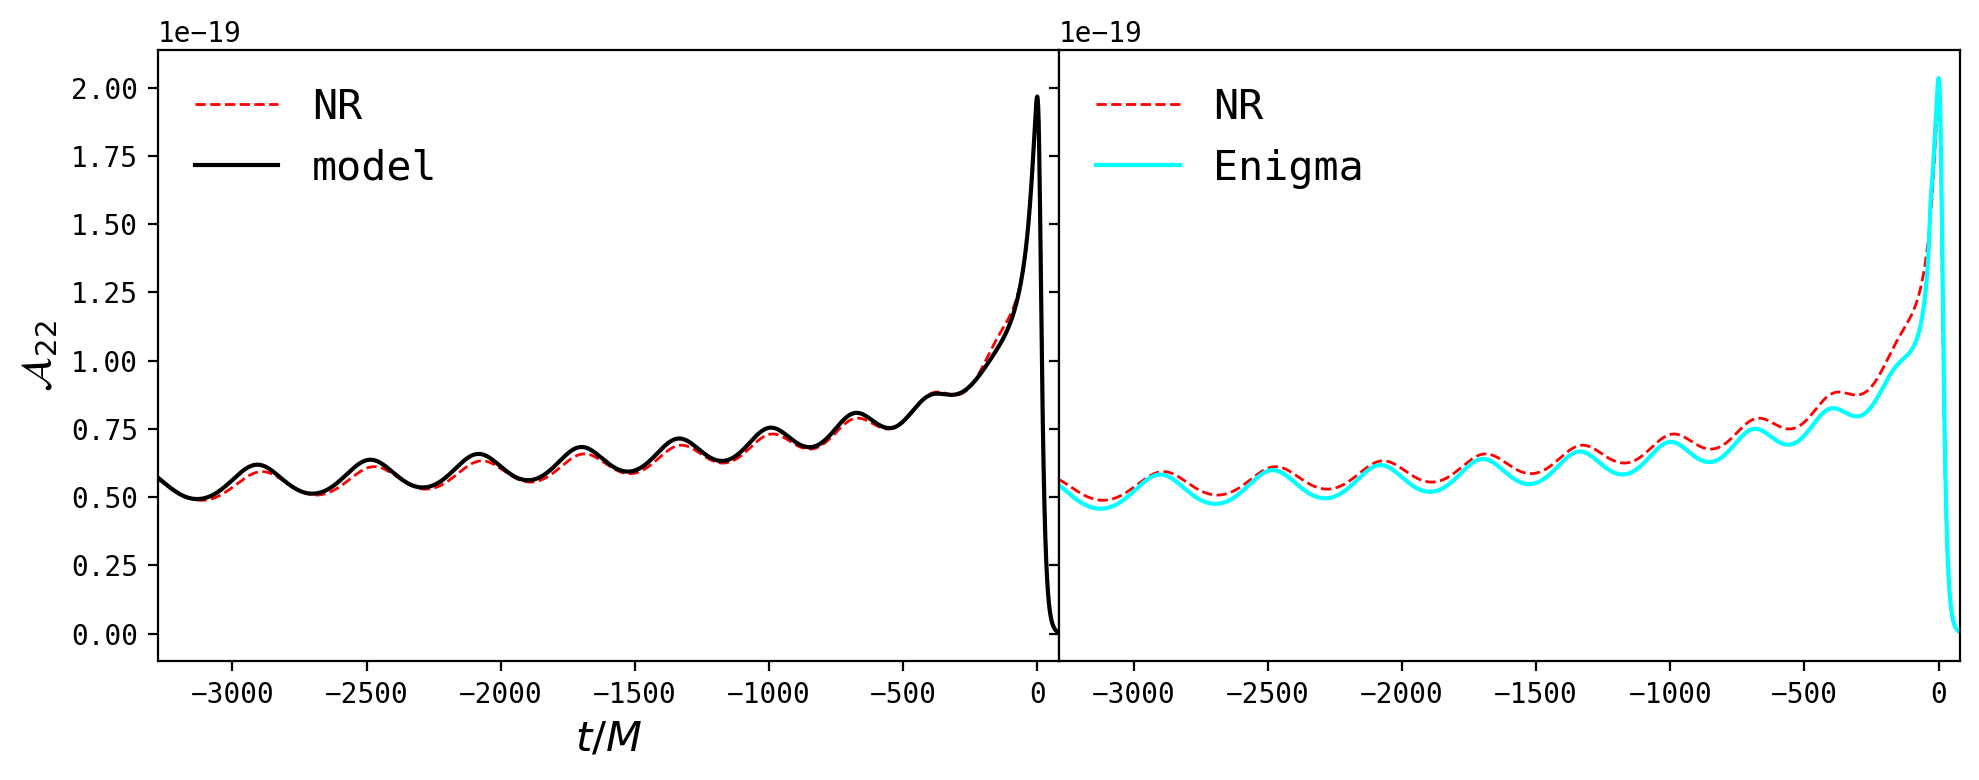

In [91]:

t = x1-x1[np.argmax(NRAmp)]

plt.figure(figsize=(10,4))
#gs = gridspec.GridSpec(1, 2, width_ratios=[8, 4]) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 4]) 
gs.update(wspace=0.0)
ax0 = plt.subplot(gs[0])
ax0.plot(x1-x1[np.argmax(NRAmp)],NRAmp,color='red',label='NR',linewidth=1,linestyle='--')
ax0.plot(t_model/(Mass*MTSUN_SI), Model_Amp, label='model',color='black',linestyle='-') #abs(hp_model+1j*hc_model))
#ax0.plot(x1-x1[np.argmax(NRAmp)],y1,color='red',label='NR',linewidth=3,linestyle='--')
#ax0.plot((t_enigma-t_enigma[np.argmax(En_Amp)])/(Mass*MTSUN_SI), hp_enigma,label='Enigma',color='cyan') #abs(hp_enigma+1j*hc_enigma))
#ax0.plot(t_model/(Mass*MTSUN_SI), hp_model, label='model',color='black',linestyle='--') #abs(hp_model+1j*hc_model))
ax0.set_xlim([t[0],80])
plt.legend(frameon=False,fontsize=15)
plt.xlabel(r'$t/M$',size=15)
plt.ylabel(r'$\mathcal{A}_{\rm 22}$',size=15)

ax1 = plt.subplot(gs[1],sharey=ax0)
ax1.plot(x1-x1[np.argmax(NRAmp)],NRAmp,color='red',label='NR',linewidth=1,linestyle='--')
ax1.plot((t_enigma-t_enigma[np.argmax(En_Amp)])/(Mass*MTSUN_SI), En_Amp,label='Enigma',color='cyan') #abs(hp_enigma+1j*hc_enigma))
#ax1.plot(t_model/(Mass*MTSUN_SI), hp_model, label='model',color='black',linestyle='--') #abs(hp_model+1j*hc_model))
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.set_xlim([t[0],80])
plt.legend(frameon=False,fontsize=15)
#plt.plot(hp_model.sample_times,hp_model)
#plt.xlim(x1[0],50)



hp_en_TS = TimeSeries(hp_enigma,delta_t)
hp_model_TS = hp_model
tlen=max(len(hp_model_TS),len(hp_en_TS))
hp_model_TS.resize(tlen)
hp_en_TS.resize(tlen)
delta_f = 1.0 / hp_model_TS.duration
flen = tlen//2 + 1
f_low = 20
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
m, i = match(hp_model_TS, hp_en_TS, psd=psd,low_frequency_cutoff=f_low)#,high_frequency_cutoff=pycbc.pnutils.f_SchwarzISCO(Mass))
#plt.savefig('Enigma-Model-NR_Comparson.pdf',dpi=300)#?match
print(m)

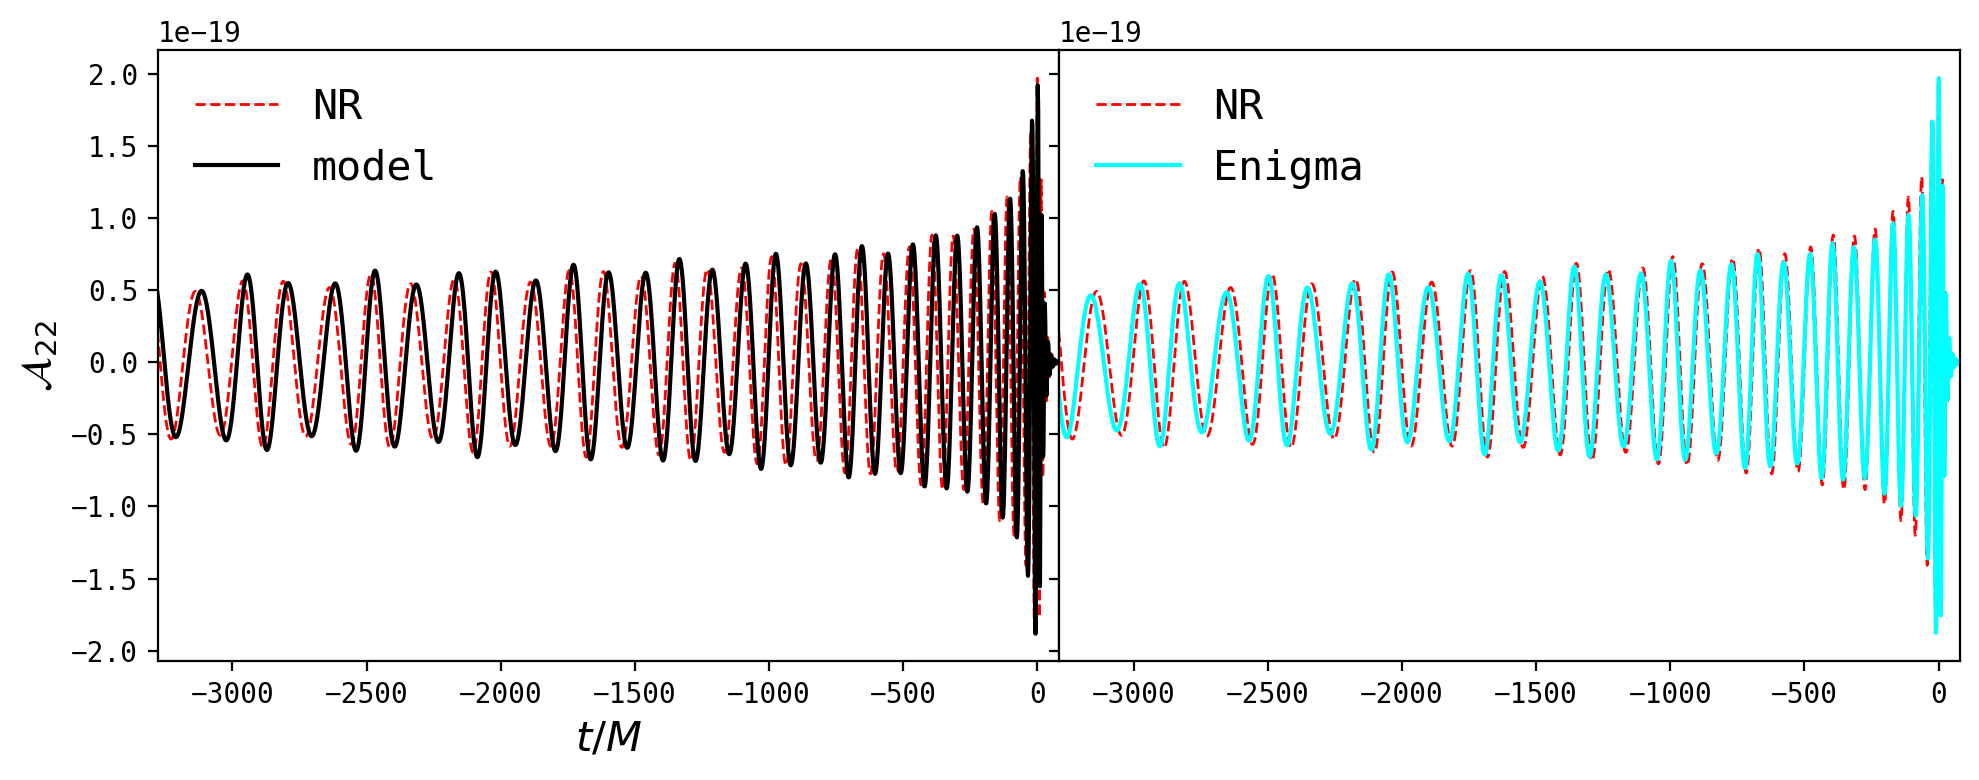

In [92]:
#En_Amp = abs(hp_enigma+1j*hc_enigma)
#Model_Amp = abs(hp_model+1j*hc_model)
t_model = hp_model.sample_times - hp_model.sample_times[np.argmax(Model_Amp)]
plt.figure(figsize=(10,4))
#gs = gridspec.GridSpec(1, 2, width_ratios=[8, 4]) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 4]) 
gs.update(wspace=0.0)
ax0 = plt.subplot(gs[0])
ax0.plot(x1-x1[np.argmax(NRAmp)],y1,color='red',label='NR',linewidth=1,linestyle='--')
ax0.plot(t_model/(Mass*MTSUN_SI), hp_model, label='model',color='black',linestyle='-') #abs(hp_model+1j*hc_model))
#ax0.plot(x1-x1[np.argmax(NRAmp)],y1,color='red',label='NR',linewidth=3,linestyle='--')
#ax0.plot((t_enigma-t_enigma[np.argmax(En_Amp)])/(Mass*MTSUN_SI), hp_enigma,label='Enigma',color='cyan') #abs(hp_enigma+1j*hc_enigma))
#ax0.plot(t_model/(Mass*MTSUN_SI), hp_model, label='model',color='black',linestyle='--') #abs(hp_model+1j*hc_model))
ax0.set_xlim([t[0],80])
plt.legend(frameon=False,fontsize=15)
plt.xlabel(r'$t/M$',size=15)
plt.ylabel(r'$\mathcal{A}_{\rm 22}$',size=15)

ax1 = plt.subplot(gs[1],sharey=ax0)
ax1.plot(x1-x1[np.argmax(NRAmp)],y1,color='red',label='NR',linewidth=1,linestyle='--')
ax1.plot((t_enigma-t_enigma[np.argmax(En_Amp)])/(Mass*MTSUN_SI), hp_enigma,label='Enigma',linestyle='-',color='cyan') #abs(hp_enigma+1j*hc_enigma))
#ax1.plot(t_model/(Mass*MTSUN_SI), hp_model, label='model',color='black',linestyle='--') #abs(hp_model+1j*hc_model))
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.set_xlim([t[0],80])
plt.legend(frameon=False,fontsize=15)
#plt.plot(hp_model.sample_times,hp_model)
#plt.xlim(x1[0],50)
#plt.savefig('Enigma-Model-NR_Comparson.pdf',dpi=300)#?match


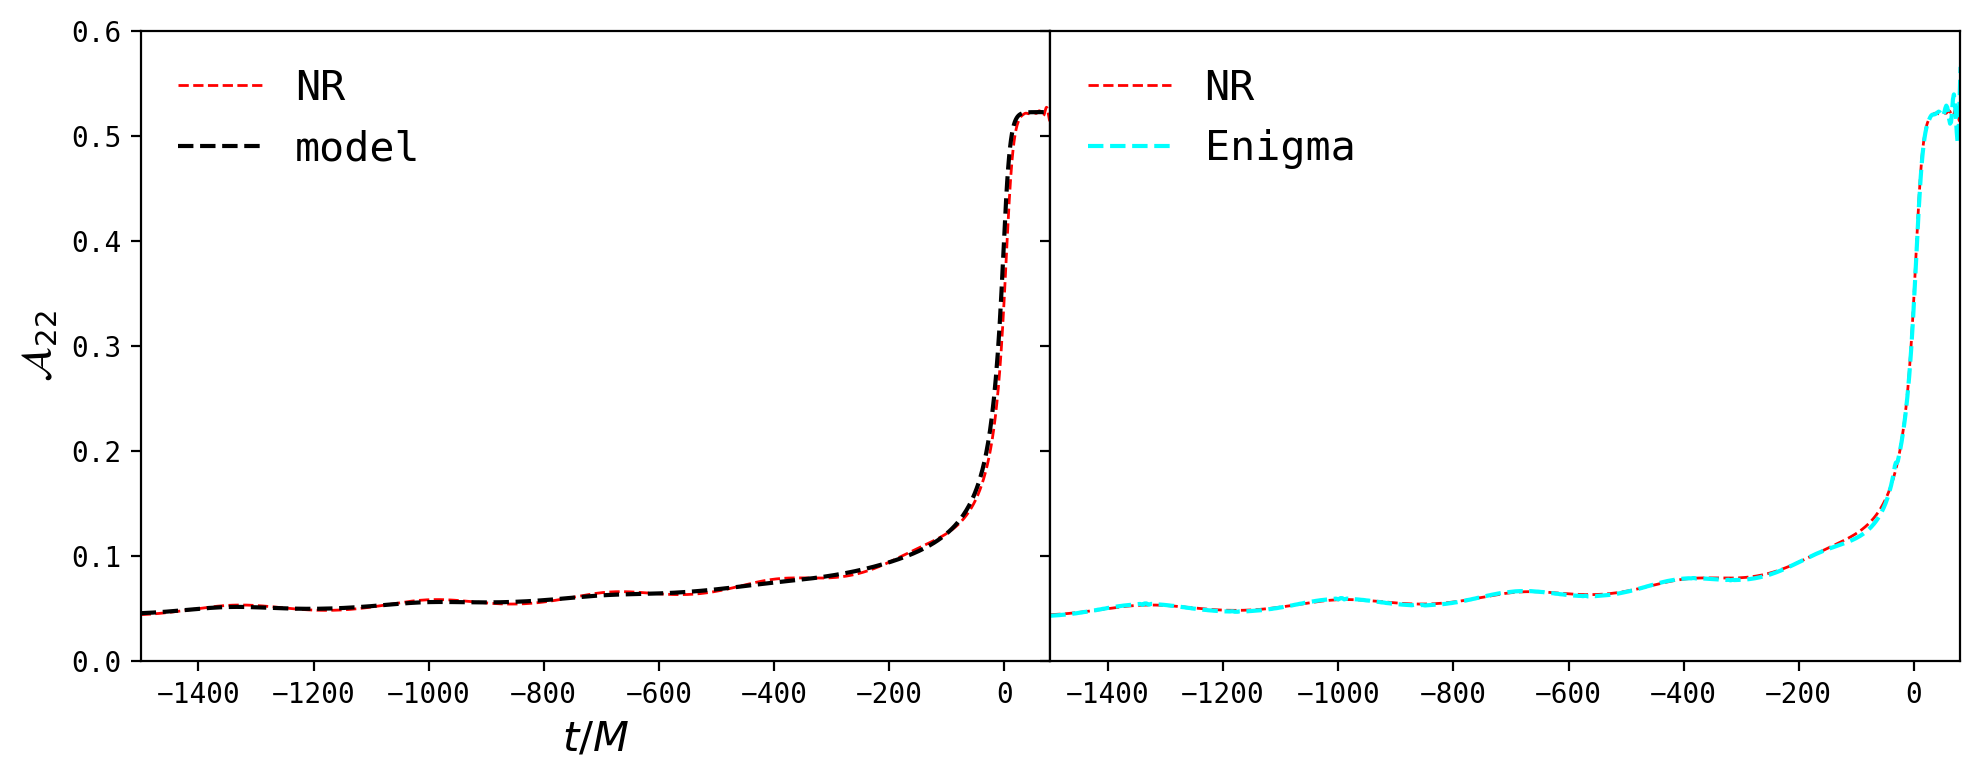

In [93]:
#En_Amp = abs(hp_enigma+1j*hc_enigma)
#Model_Amp = abs(hp_model+1j*hc_model)
#t_model = hp_model.sample_times - hp_model.sample_times[np.argmax(Model_Amp)]
plt.figure(figsize=(10,4))
#gs = gridspec.GridSpec(1, 2, width_ratios=[8, 4]) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 4]) 
gs.update(wspace=0.0)
ax0 = plt.subplot(gs[0])
ax0.plot(np.delete(x1-x1[np.argmax(NRAmp)],-1),w,color='red',label='NR',linewidth=1,linestyle='--')
ax0.plot(times/(Mass*MTSUN_SI), omega_model, label='model',color='black',linestyle='--') #abs(hp_model+1j*hc_model))
#ax0.plot(x1-x1[np.argmax(NRAmp)],y1,color='red',label='NR',linewidth=3,linestyle='--')
#ax0.plot((t_enigma-t_enigma[np.argmax(En_Amp)])/(Mass*MTSUN_SI), hp_enigma,label='Enigma',color='cyan') #abs(hp_enigma+1j*hc_enigma))
#ax0.plot(t_model/(Mass*MTSUN_SI), hp_model, label='model',color='black',linestyle='--') #abs(hp_model+1j*hc_model))
ax0.set_xlim([-1500,80])
ax0.set_ylim([0,0.6])
plt.legend(frameon=False,fontsize=15)
plt.xlabel(r'$t/M$',size=15)
plt.ylabel(r'$\mathcal{A}_{\rm 22}$',size=15)

ax1 = plt.subplot(gs[1],sharey=ax0)
ax1.plot(np.delete(x1-x1[np.argmax(NRAmp)],-1),w,color='red',label='NR',linewidth=1,linestyle='--')
ax1.plot((t_enigma-t_enigma[np.argmax(En_Amp)])/(Mass*MTSUN_SI), omega_En,label='Enigma',color='cyan',linestyle='--') #abs(hp_enigma+1j*hc_enigma))
#ax1.plot(t_model/(Mass*MTSUN_SI), hp_model, label='model',color='black',linestyle='--') #abs(hp_model+1j*hc_model))
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.set_xlim([-1500,80])
ax1.set_ylim([0,0.6])
plt.legend(frameon=False,fontsize=15)
#plt.plot(hp_model.sample_times,hp_model)
#plt.xlim(x1[0],50)

In [ ]:
# Identical parameter space match calculations

def func(M):
    Mass = M
    for i in range(len(q0)):
        q = q0[i]
        e = e0[i]
        l = l0[i]
        inc = 0 
        d = 1
        fmin = fconv(xconv(f0[i],30),Mass) #fconv(0.045,Mass) 
        fref = fconv(0.075,Mass)
        delta_t = 1/4096
        hp_enigma, hc_enigma, t_enigma = enigma_gen(Mass,q,e,fmin,fref,delta_t)
        hp_model, hc_model,_ = model_22(Mass,q,e,l,fmin,inc,d,delta_t)
    
        hp_en_TS = TimeSeries(hp_enigma,delta_t)
        tlen=max(len(hp_model),len(hp_en_TS))
        hp_model.resize(tlen)
        hp_en_TS.resize(tlen)
        delta_f = 1.0 / hp_model.duration
        flen = tlen//2 + 1
        f_low = 20
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        m, i = match(hp_model, hp_en_TS, psd=psd, low_frequency_cutoff=f_low)#, high_frequency_cutoff=pycbc.pnutils.f_SchwarzISCO(Mass))
        print(m)
    

In [ ]:
func(30)

## EccentricTD - ENIGMA Match

In [ ]:
#?ls.SimInspiralChooseTDWaveform

In [ ]:
Mass = 20
q = 2
M1 = q/(1+q)*Mass
M2 = 1/(1+q)*Mass

e = 0.2 #e0[0]
l = 0
inc = 0 
d = 1


fmin = 20#fconv(xconv(16.68,30),Mass)
fref = 20 #fconv(0.095,Mass)
delta_t = 1/4096
hp_enigma, hc_enigma = ls.SimInspiralChooseTDWaveform(M1*lal.MSUN_SI, M2*lal.MSUN_SI, 0, 0, 0, 0, 0, 0, d*lal.PC_SI, 0, 0, 0, e, 0, delta_t, fmin, fref, None, ls.IMRENIGMA)
hp, hc = ls.SimInspiralChooseTDWaveform(M1*lal.MSUN_SI, M2*lal.MSUN_SI, 0, 0, 0, 0, 0, 0, d*lal.PC_SI, 0, 0, 0, e, 0, delta_t, fmin, fref, None, ls.EccentricTD)

In [ ]:
plt.figure(figsize=(12,3))

hp_en_TS = TimeSeries(hp_enigma.data.data,delta_t)
hc_en_TS = TimeSeries(hc_enigma.data.data,delta_t)

hp_ecc_TS = TimeSeries(hp.data.data,delta_t)
hc_ecc_TS = TimeSeries(hc.data.data,delta_t)

plt.plot(hp_en_TS.sample_times, abs(hp_en_TS+1j*hc_en_TS), label='ENIGMA')
plt.plot(hp_ecc_TS.sample_times, abs(hp_ecc_TS+1j*hc_ecc_TS), label='EccTD')
plt.legend(frameon=False)


tlen=max(len(hp_ecc_TS),len(hp_en_TS))
hp_ecc_TS.resize(tlen)
hp_en_TS.resize(tlen)
delta_f = 1.0 / hp_ecc_TS.duration
flen = tlen//2 + 1
f_low = 20
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
m, i = match(hp_ecc_TS, hp_en_TS, psd=psd,low_frequency_cutoff=f_low)#,high_frequency_cutoff=87.94349521273607)
#?match
print(m)

In [ ]:

#convert

In [ ]:
pycbc.pnutils.f_SchwarzISCO(50)